In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
# Define dataset paths
dataset_path = "/content/drive/MyDrive/cassava_dataset"
image_folder = os.path.join(dataset_path, "train_images")
csv_file = os.path.join(dataset_path, "train.csv")

# Load CSV file
df = pd.read_csv(csv_file)

# Check the first few rows
print(df.head())
print(df['image_id'].head())  # Check the first few filenames




         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
0    1000015157.jpg
1    1000201771.jpg
2     100042118.jpg
3    1000723321.jpg
4    1000812911.jpg
Name: image_id, dtype: object


In [ ]:
image_folder = "/content/drive/MyDrive/cassava_dataset/train_images"

if os.path.exists(image_folder):
    print("Image folder exists")
    print("Sample images in directory:", os.listdir(image_folder)[:10])  # Show first 10 images
else:
    print("Image folder does NOT exist! Check your Google Drive path.")

print(os.listdir(image_folder)[:10])  # Show the first 10 image names



Image folder exists
Sample images in directory: ['805835204.jpg', '808870213.jpg', '807190211.jpg', '80998969.jpg', '807555228.jpg', '806670613.jpg', '808606006.jpg', '804903970.jpg', '809489252.jpg', '807063038.jpg']
['805835204.jpg', '808870213.jpg', '807190211.jpg', '80998969.jpg', '807555228.jpg', '806670613.jpg', '808606006.jpg', '804903970.jpg', '809489252.jpg', '807063038.jpg']


In [ ]:
# Define class names mapping
label_to_class = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy"
}

# Display the label-to-class mapping
print("Label to Class Mapping:")
for label, class_name in label_to_class.items():
    print(f"{label}: {class_name}")

Label to Class Mapping:
0: Cassava Bacterial Blight (CBB)
1: Cassava Brown Streak Disease (CBSD)
2: Cassava Green Mottle (CGM)
3: Cassava Mosaic Disease (CMD)
4: Healthy


In [ ]:
# Define paths
csv_path = "/content/drive/MyDrive/cassava_dataset/train.csv"
image_folder = "/content/drive/MyDrive/cassava_dataset/train_images"

# Load train.csv
df = pd.read_csv(csv_path)

# Get lists of image names
csv_images = set(df['image_id'])  # Images listed in CSV
folder_images = set(os.listdir(image_folder))  # Images in train_images folder

# Identify missing and extra images
missing_images = csv_images - folder_images  # In CSV but not in folder
extra_images = folder_images - csv_images  # In folder but not in CSV

# Print results
print(f"Total images in CSV: {len(csv_images)}")
print(f"Total images in folder: {len(folder_images)}")
print(f"Missing images (in CSV but not in folder): {len(missing_images)}")
print(f"Extra images (in folder but not in CSV): {len(extra_images)}")

Total images in CSV: 21397
Total images in folder: 17938
Missing images (in CSV but not in folder): 3459
Extra images (in folder but not in CSV): 0


In [ ]:
# Remove rows in df where images are missing
df = df[~df['image_id'].isin(missing_images)]

# Save cleaned CSV (optional, for future use)
cleaned_csv_path = "/content/drive/MyDrive/cassava_dataset/train_cleaned.csv"
df.to_csv(cleaned_csv_path, index=False)

print(f"Updated dataset size: {len(df)}")


Updated dataset size: 17938


In [ ]:
for img in extra_images:
    img_path = os.path.join(image_folder, img)
    os.remove(img_path)  # Delete extra image

print("Extra images removed successfully!")


Extra images removed successfully!


In [ ]:

# Define constants
IMG_SIZE = 128
BATCH_SIZE = 16

# Define paths
dataset_path = "/content/drive/MyDrive/cassava_dataset"
csv_path = os.path.join(dataset_path, "train.csv")
image_folder = os.path.join(dataset_path, "train_images")

# Load dataset
df = pd.read_csv(csv_path)

# Get actual image filenames from the folder
available_images = set(os.listdir(image_folder))

# Remove rows where images are missing
df = df[df['image_id'].isin(available_images)].reset_index(drop=True)

# Print dataset stats
print(f"Total images in CSV (after cleaning): {len(df)}")
print(f"Total images available in folder: {len(available_images)}")

# Function to preprocess images
def preprocess_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise Exception("Corrupt Image")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # Resize to 128x128
        img = img / 255.0  # Normalize pixel values to [0,1]
        return img
    except:
        print(f"Warning: Could not read image {img_path}")
        return np.zeros((IMG_SIZE, IMG_SIZE, 3))  # Return blank image

# Split dataset into train, validation, test
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)






Total images in CSV (after cleaning): 17938
Total images available in folder: 17938


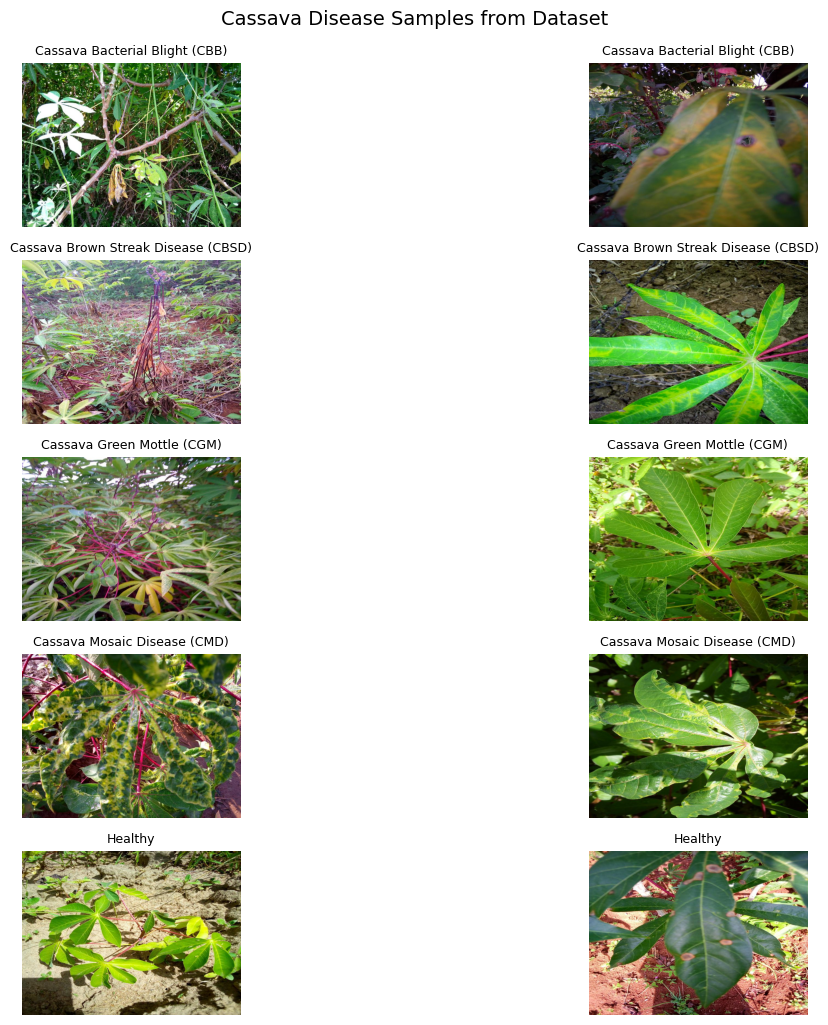

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

# Define your label mapping (adjust if different)
label_to_disease = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy"
}

# Create a figure to display samples
plt.figure(figsize=(15, 10))

# Select samples - 2 per class for balanced view
samples_per_class = 2
for class_id, disease_name in label_to_disease.items():
    # Get samples for this class
    class_samples = df[df['label'] == class_id].sample(samples_per_class)

    for i, (_, row) in enumerate(class_samples.iterrows()):
        img_path = os.path.join(image_folder, row['image_id'])
        try:
            img = Image.open(img_path)

            # Create subplot
            plt.subplot(len(label_to_disease), samples_per_class,
                       class_id * samples_per_class + i + 1)
            plt.imshow(img)
            plt.title(f"{disease_name}", fontsize=9)
            plt.axis('off')

        except Exception as e:
            print(f"Error loading {img_path}: {e}")

plt.tight_layout()
plt.suptitle("Cassava Disease Samples from Dataset", y=1.02, fontsize=14)
plt.savefig('disease_samples.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Define Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=30,       # Random rotation (0-30 degrees)
    width_shift_range=0.2,   # Horizontal shift (up to 20% of width)
    height_shift_range=0.2,  # Vertical shift (up to 20% of height)
    shear_range=0.2,         # Shearing transformation (distorts shape)
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill missing pixels after transformation
)

#Validation & Test Preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation & test

# Convert 'label' column to string type
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

# Create Data Generators
#train generator(with augumentation)
train_generator = train_datagen.flow_from_dataframe(
    df_train, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse"
)

#Validation Generator-Only rescales images (no augmentation)
val_generator = val_datagen.flow_from_dataframe(
    df_val, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse"
)

#Test Generator (For Final Evaluation)
test_generator = val_datagen.flow_from_dataframe(
    df_test, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse",
    shuffle=False  # No need to shuffle test data
)

# Print dataset sizes
print(f"Train size: {len(df_train)}, Validation size: {len(df_val)}, Test size: {len(df_test)}")
print(" Data preprocessing & augmentation completed successfully!")


Found 12556 validated image filenames belonging to 5 classes.
Found 2691 validated image filenames belonging to 5 classes.
Found 2691 validated image filenames belonging to 5 classes.
Train size: 12556, Validation size: 2691, Test size: 2691
 Data preprocessing & augmentation completed successfully!


In [ ]:
#Hybrid model

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os

# Enable mixed precision for faster training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Define input shape
IMG_SIZE = 128  # Reduced image size for faster processing
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = 5
BATCH_SIZE = 16  # Reduced batch size for faster training

# Custom CNN Model (Simplified)
def build_custom_cnn(input_shape):
    cnn_model = Sequential([
        Conv2D(32, (3,3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5)
    ])
    return cnn_model

# MobileNetV2 Model (Frozen)
def build_mobilenet(input_shape):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the entire base model initially
    return base_model

# Create models
cnn_model = build_custom_cnn(input_shape)
mobilenet_model = build_mobilenet(input_shape)

# Merge CNN and MobileNetV2 Outputs
single_input = Input(shape=input_shape)
cnn_output = cnn_model(single_input)
mobilenet_output = GlobalAveragePooling2D()(mobilenet_model(single_input))
merged = Concatenate()([cnn_output, mobilenet_output])
final_output = Dense(256, activation='relu')(merged)
final_output = Dropout(0.5)(final_output)
final_output = Dense(num_classes, activation='softmax')(final_output)

# Define final hybrid model
hybrid_model = Model(inputs=single_input, outputs=final_output)

# Compile model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Model summary
hybrid_model.summary()

# Define callbacks
callbacks = [
    ModelCheckpoint("best_hybrid_model.h5", save_best_only=True, monitor="val_loss", mode="min"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, mode="min"),

]
# Train the model
history = hybrid_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)

# Evaluate the hybrid model on test set
test_loss, test_acc = hybrid_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save final model
hybrid_model.save("cassava_hybrid_cnn_mobilenet.keras")
print("Hybrid Model saved successfully!")





/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 4, 4,      │  2,257,984 │ input_layer_2[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │  8,408,512 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1408)      │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    360,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │      1,285 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,028,485 (42.07 MB)

 Trainable params: 8,770,309 (33.46 MB)

 Non-trainable params: 2,258,176 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5380 - loss: 1.6270

785/785 ━━━━━━━━━━━━━━━━━━━━ 228s 267ms/step - accuracy: 0.5381 - loss: 1.6264 - val_accuracy: 0.6485 - val_loss: 0.9993 - learning_rate: 1.0000e-04
Epoch 2/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 225s 234ms/step - accuracy: 0.6574 - loss: 0.9852 - val_accuracy: 0.6228 - val_loss: 1.0203 - learning_rate: 1.0000e-04
Epoch 3/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6538 - loss: 0.9583

785/785 ━━━━━━━━━━━━━━━━━━━━ 199s 230ms/step - accuracy: 0.6538 - loss: 0.9582 - val_accuracy: 0.6466 - val_loss: 0.9882 - learning_rate: 1.0000e-04
Epoch 4/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6684 - loss: 0.9175

785/785 ━━━━━━━━━━━━━━━━━━━━ 176s 197ms/step - accuracy: 0.6685 - loss: 0.9175 - val_accuracy: 0.6410 - val_loss: 0.9632 - learning_rate: 1.0000e-04
Epoch 5/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6729 - loss: 0.9055

785/785 ━━━━━━━━━━━━━━━━━━━━ 149s 190ms/step - accuracy: 0.6729 - loss: 0.9055 - val_accuracy: 0.6574 - val_loss: 0.9497 - learning_rate: 1.0000e-04
Epoch 6/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 205s 194ms/step - accuracy: 0.6910 - loss: 0.8652 - val_accuracy: 0.6195 - val_loss: 1.0298 - learning_rate: 1.0000e-04
Epoch 7/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 205s 198ms/step - accuracy: 0.6925 - loss: 0.8731 - val_accuracy: 0.6013 - val_loss: 1.0511 - learning_rate: 1.0000e-04
Epoch 8/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6929 - loss: 0.8535
Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
785/785 ━━━━━━━━━━━━━━━━━━━━ 204s 201ms/step - accuracy: 0.6928 - loss: 0.8535 - val_accuracy: 0.6373 - val_loss: 0.9981 - learning_rate: 1.0000e-04
Epoch 9/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 198s 195ms/step - accuracy: 0.6874 - loss: 0.8588 - val_accuracy: 0.6451 - val_loss: 0.9749 - learning_rate: 2.0000e-05
Epoch 10/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 201s 194ms/step 

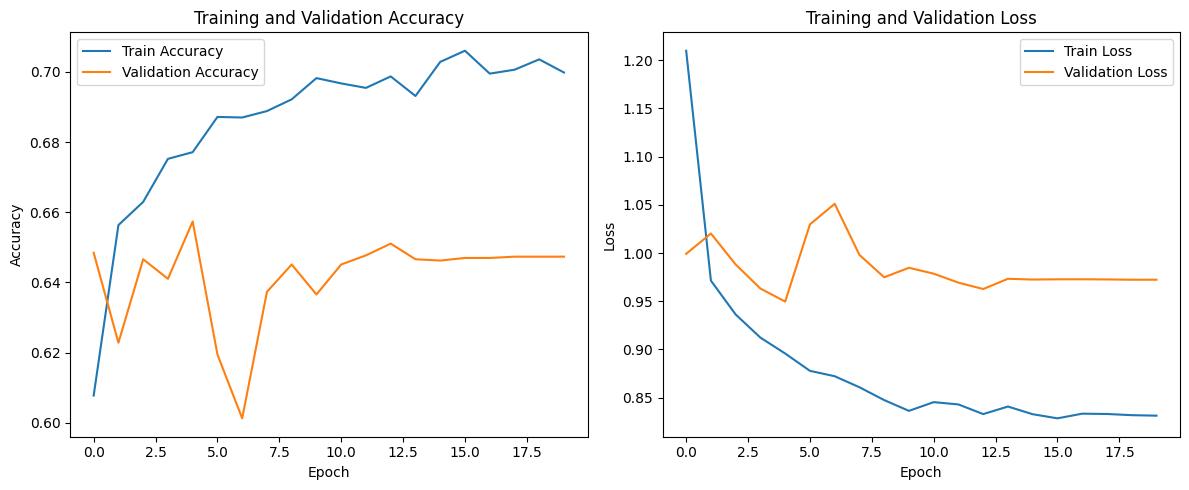

In [ ]:
# Accuracy and Loss plot of Hybrid Model

import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step


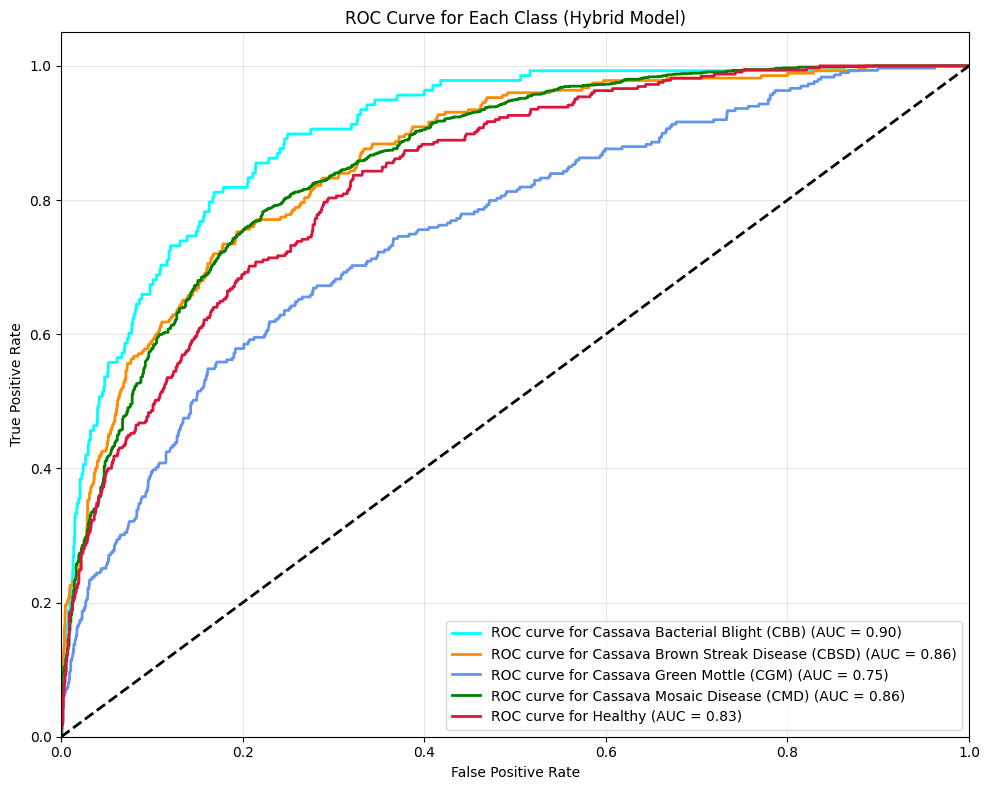

In [ ]:
#ROC Curve
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

#  class names
class_names = ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)',
               'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']

# Number of classes
n_classes = len(class_names)

# Get true labels and predicted probabilities from hybrid model
# 'y_true' should be class indices (e.g. [0, 1, 2, 0, 4, ...])
# 'y_score' should be predicted probabilities (output from model.predict)
y_true = test_generator.classes
y_score = hybrid_model.predict(test_generator)

# Binarize the true labels for ROC calculation
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'crimson'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (Hybrid Model)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Hybrid model-Precision,Recall, and F1 score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Evaluate the model on the test set
test_loss, test_accuracy = hybrid_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Get predictions from the test set
y_pred = hybrid_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels
y_true = test_generator.labels

# Compute precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))



169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.6188 - loss: 1.0042
Test Loss: 0.9640
Test Accuracy: 64.07%
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step
Precision: 0.6858
Recall: 0.6407
F1-Score: 0.6468

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.16      0.25       138
           1       0.47      0.48      0.48       275
           2       0.42      0.28      0.34       299
           3       0.85      0.76      0.81      1654
           4       0.32      0.68      0.44       325

    accuracy                           0.64      2691
   macro avg       0.53      0.47      0.46      2691
weighted avg       0.69      0.64      0.65      2691



In [ ]:
from google.colab import files
files.download("cassava_hybrid_cnn_mobilenet.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install ipywidgets
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.8 MB/s eta 0:00:00


In [ ]:
#hybrid model importing from drive

from google.colab import drive
import tensorflow as tf

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Path to your saved model
model_path = '/content/drive/MyDrive/cassava_hybrid_cnn_mobilenet.keras'

# Load the model
try:
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully from Google Drive!")
except Exception as e:
    print(f"Error loading model: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Error loading model: File not found: filepath=/content/drive/MyDrive/cassava_hybrid_cnn_mobilenet.keras. Please ensure the file is an accessible `.keras` zip file.


In [ ]:
#Prediction of Hybrid Model

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from PIL import Image
import cv2
import numpy as np

def preprocess_image(image):
    """Preprocess image for model prediction"""
    img = cv2.resize(image, (128, 128))  # Resize to model input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Define class names
class_names = [
    "Cassava Bacterial Blight (CBB)",
    "Cassava Brown Streak Disease (CBSD)",
    "Cassava Green Mottle (CGM)",
    "Cassava Mosaic Disease (CMD)",
    "Healthy"
]

# Create interactive widgets
path_text = widgets.Text(
    placeholder='Enter path to cassava leaf image',
    description='Image Path:',
    style={'description_width': 'initial'}
)

predict_button = widgets.Button(
    description='Diagnose',
    button_style='info',
    tooltip='Click to analyze disease',
    icon='search'
)

output = widgets.Output()

def on_predict_button_clicked(b):
    if path_text.value:
        output.clear_output()

        with output:
            try:
                # Load and display image
                display(HTML("<h3>Input Leaf Image:</h3>"))
                pil_img = Image.open(path_text.value)
                display(pil_img)

                # Convert and preprocess
                img_array = np.array(pil_img)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
                processed_img = preprocess_image(img_array)

                # Make prediction
                predictions = hybrid_model.predict(processed_img)[0]
                predicted_class = np.argmax(predictions)

                # Display results
                display(HTML("<h3>Diagnosis Results:</h3>"))

                # Create confidence percentage display
                confidence_html = "<div style='font-family: monospace;'>"
                for i, (class_name, prob) in enumerate(zip(class_names, predictions)):
                    confidence_pct = prob * 100
                    bar_width = int(confidence_pct / 2)  # Scale for visual display
                    confidence_html += (
                        f"<div style='margin-bottom: 5px;'>"
                        f"<strong>{class_name}:</strong> "
                        f"{confidence_pct:.2f}% "
                        f"<div style='background: {'#4CAF50' if i == predicted_class else '#f44336'}; "
                        f"width: {bar_width}px; height: 20px; display: inline-block;'></div>"
                        f"</div>"
                    )
                confidence_html += "</div>"

                display(HTML(confidence_html))
                display(HTML(
                    f"<div style='font-size: 1.2em; margin-top: 10px;'>"
                    f"<strong>Most Likely:</strong> {class_names[predicted_class]} "
                    f"({predictions[predicted_class]*100:.2f}% confidence)"
                    f"</div>"
                ))

            except Exception as e:
                display(HTML(f"<div style='color: red;'>Error: {str(e)}</div>"))

predict_button.on_click(on_predict_button_clicked)

# Display the interface
display(HTML("<h2>Cassava Disease Classifier</h2>"))
display(widgets.VBox([
    widgets.HBox([path_text, predict_button]),
    output
]))

In [ ]:
/content/drive/MyDrive/cassava_dataset/train_images/1593718763.jpg

In [ ]:
#EfficientNet

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=30,       # Random rotation (0-30 degrees)
    width_shift_range=0.2,   # Horizontal shift (up to 20% of width)
    height_shift_range=0.2,  # Vertical shift (up to 20% of height)
    shear_range=0.2,         # Shearing transformation (distorts shape)
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill missing pixels after transformation
)

#Validation & Test Preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation & test

# Convert 'label' column to string type
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

# Create Data Generators
#train generator(with augumentation)
train_generator = train_datagen.flow_from_dataframe(
    df_train, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse"
)

#Validation Generator-Only rescales images (no augmentation)
val_generator = val_datagen.flow_from_dataframe(
    df_val, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse"
)

#Test Generator (For Final Evaluation)
test_generator = val_datagen.flow_from_dataframe(
    df_test, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse",
    shuffle=False
)

# Print dataset sizes
print(f"Train size: {len(df_train)}, Validation size: {len(df_val)}, Test size: {len(df_test)}")
print(" Data preprocessing & augmentation completed successfully!")



# Define constants
IMG_SIZE = 128
BATCH_SIZE = 16
NUM_CLASSES = 5

# Load EfficientNetB0 model
def build_efficientnet_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation="softmax")(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Build the EfficientNet model
efficientnet_model = build_efficientnet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)

# Compile the model
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Model summary
efficientnet_model.summary()

# Define callbacks
callbacks = [
    ModelCheckpoint("best_efficientnet_model.h5", save_best_only=True, monitor="val_loss", mode="min"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, mode="min"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

# Train the EfficientNet model
history_efficientnet = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)

# Evaluate the EfficientNet model on the test set
test_loss_efficientnet, test_acc_efficientnet = efficientnet_model.evaluate(test_generator)
print(f"EfficientNet Test Accuracy: {test_acc_efficientnet * 100:.2f}%")

# Save the EfficientNet model
efficientnet_model.save("efficientnet_model.keras")
print("EfficientNet Model saved successfully!")

Found 12556 validated image filenames belonging to 5 classes.
Found 2691 validated image filenames belonging to 5 classes.
Found 2691 validated image filenames belonging to 5 classes.
Train size: 12556, Validation size: 2691, Test size: 2691
 Data preprocessing & augmentation completed successfully!


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_4 (Cast)       │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ cast_4[0][0]      │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6037 - loss: 1.2299

785/785 ━━━━━━━━━━━━━━━━━━━━ 205s 230ms/step - accuracy: 0.6037 - loss: 1.2299 - val_accuracy: 0.6150 - val_loss: 1.1922 - learning_rate: 1.0000e-04
Epoch 2/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6122 - loss: 1.2105

785/785 ━━━━━━━━━━━━━━━━━━━━ 149s 189ms/step - accuracy: 0.6122 - loss: 1.2105 - val_accuracy: 0.6150 - val_loss: 1.1833 - learning_rate: 1.0000e-04
Epoch 3/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 205s 193ms/step - accuracy: 0.6155 - loss: 1.2004 - val_accuracy: 0.6150 - val_loss: 1.1846 - learning_rate: 1.0000e-04
Epoch 4/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6152 - loss: 1.2020

785/785 ━━━━━━━━━━━━━━━━━━━━ 202s 193ms/step - accuracy: 0.6152 - loss: 1.2020 - val_accuracy: 0.6150 - val_loss: 1.1824 - learning_rate: 1.0000e-04
Epoch 5/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6133 - loss: 1.2014

785/785 ━━━━━━━━━━━━━━━━━━━━ 154s 197ms/step - accuracy: 0.6134 - loss: 1.2014 - val_accuracy: 0.6150 - val_loss: 1.1808 - learning_rate: 1.0000e-04
Epoch 6/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 153s 194ms/step - accuracy: 0.6171 - loss: 1.2023 - val_accuracy: 0.6150 - val_loss: 1.1825 - learning_rate: 1.0000e-04
Epoch 7/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 153s 194ms/step - accuracy: 0.6108 - loss: 1.2091 - val_accuracy: 0.6150 - val_loss: 1.1810 - learning_rate: 1.0000e-04
Epoch 8/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6143 - loss: 1.1994
Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
785/785 ━━━━━━━━━━━━━━━━━━━━ 203s 196ms/step - accuracy: 0.6143 - loss: 1.1994 - val_accuracy: 0.6150 - val_loss: 1.1814 - learning_rate: 1.0000e-04
Epoch 9/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6193 - loss: 1.1871

785/785 ━━━━━━━━━━━━━━━━━━━━ 153s 195ms/step - accuracy: 0.6193 - loss: 1.1871 - val_accuracy: 0.6150 - val_loss: 1.1805 - learning_rate: 2.0000e-05
Epoch 10/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 202s 194ms/step - accuracy: 0.6155 - loss: 1.2003 - val_accuracy: 0.6150 - val_loss: 1.1808 - learning_rate: 2.0000e-05
Epoch 11/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6140 - loss: 1.1992

785/785 ━━━━━━━━━━━━━━━━━━━━ 200s 192ms/step - accuracy: 0.6140 - loss: 1.1991 - val_accuracy: 0.6150 - val_loss: 1.1803 - learning_rate: 2.0000e-05
Epoch 12/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6089 - loss: 1.2035

785/785 ━━━━━━━━━━━━━━━━━━━━ 203s 194ms/step - accuracy: 0.6089 - loss: 1.2034 - val_accuracy: 0.6150 - val_loss: 1.1799 - learning_rate: 2.0000e-05
Epoch 13/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6203 - loss: 1.1908

785/785 ━━━━━━━━━━━━━━━━━━━━ 202s 195ms/step - accuracy: 0.6203 - loss: 1.1908 - val_accuracy: 0.6150 - val_loss: 1.1799 - learning_rate: 2.0000e-05
Epoch 14/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6157 - loss: 1.1980

785/785 ━━━━━━━━━━━━━━━━━━━━ 157s 200ms/step - accuracy: 0.6157 - loss: 1.1980 - val_accuracy: 0.6150 - val_loss: 1.1798 - learning_rate: 2.0000e-05
Epoch 15/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6155 - loss: 1.1918

785/785 ━━━━━━━━━━━━━━━━━━━━ 200s 198ms/step - accuracy: 0.6155 - loss: 1.1919 - val_accuracy: 0.6150 - val_loss: 1.1797 - learning_rate: 2.0000e-05
Epoch 16/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 199s 194ms/step - accuracy: 0.6180 - loss: 1.1881 - val_accuracy: 0.6150 - val_loss: 1.1800 - learning_rate: 2.0000e-05
Epoch 17/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 154s 196ms/step - accuracy: 0.6204 - loss: 1.1890 - val_accuracy: 0.6150 - val_loss: 1.1798 - learning_rate: 2.0000e-05
Epoch 18/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6101 - loss: 1.1988

785/785 ━━━━━━━━━━━━━━━━━━━━ 160s 204ms/step - accuracy: 0.6101 - loss: 1.1988 - val_accuracy: 0.6150 - val_loss: 1.1793 - learning_rate: 2.0000e-05
Epoch 19/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step - accuracy: 0.6137 - loss: 1.2031 - val_accuracy: 0.6150 - val_loss: 1.1809 - learning_rate: 2.0000e-05
Epoch 20/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6146 - loss: 1.1952

785/785 ━━━━━━━━━━━━━━━━━━━━ 154s 196ms/step - accuracy: 0.6146 - loss: 1.1952 - val_accuracy: 0.6150 - val_loss: 1.1792 - learning_rate: 2.0000e-05
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.6201 - loss: 1.1708
EfficientNet Test Accuracy: 61.46%
EfficientNet Model saved successfully!


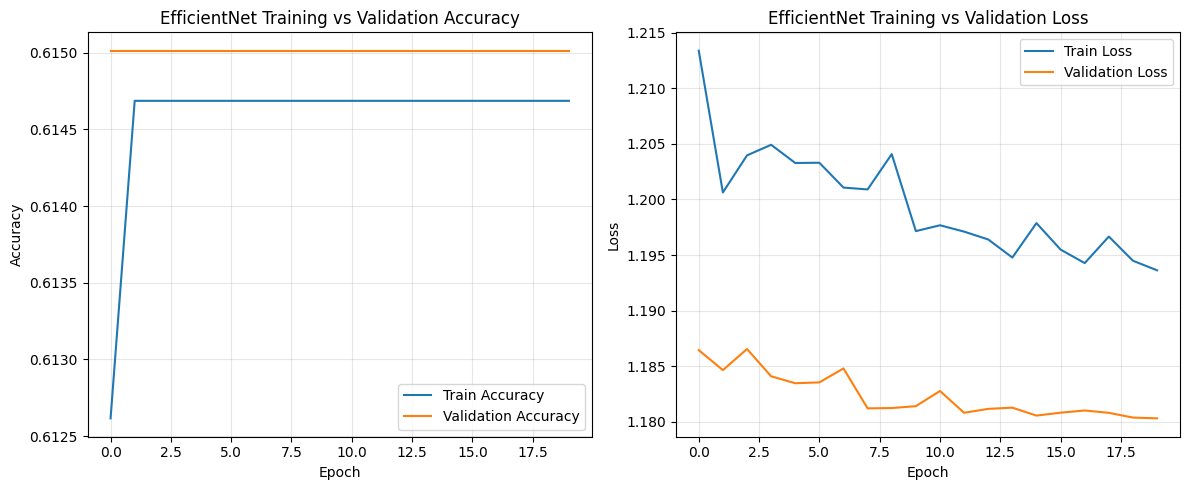

In [ ]:
#Accuracy and Loss plot of EfficientNet Model

import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNet Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.title('EfficientNet Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('efficientnet_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Get precison, recall and f1 score for efficientnet
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions from the test set
y_pred_efficientnet = efficientnet_model.predict(test_generator)
y_pred_efficientnet = np.argmax(y_pred_efficientnet, axis=1)

# Get true labels
y_true = test_generator.labels


# Classification Report for EfficientNet
print("EfficientNet Classification Report:")
print(classification_report(y_true, y_pred_efficientnet, target_names=class_names))



169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step
EfficientNet Classification Report:
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.00      0.00      0.00       138
Cassava Brown Streak Disease (CBSD)       0.00      0.00      0.00       275
         Cassava Green Mottle (CGM)       0.00      0.00      0.00       299
       Cassava Mosaic Disease (CMD)       0.61      1.00      0.76      1654
                            Healthy       0.00      0.00      0.00       325

                           accuracy                           0.61      2691
                          macro avg       0.12      0.20      0.15      2691
                       weighted avg       0.38      0.61      0.47      2691



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step


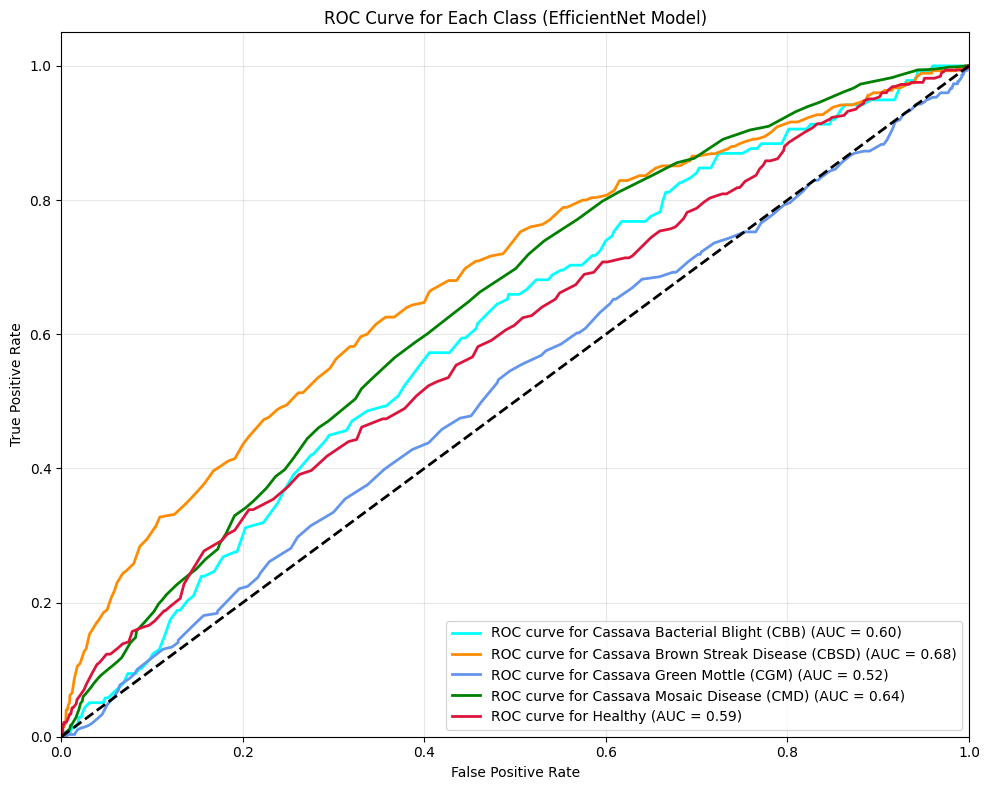

In [ ]:
# EfficientNet ROC Curve
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Class names in the same order as EfficientNet's output
class_names = ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)',
               'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']

n_classes = len(class_names)



# True labels and predicted probabilities from EfficientNet
y_true = test_generator.classes
y_score = efficientnet_model.predict(test_generator)

# Binarize the true labels for ROC computation
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])

# Compute ROC curves and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'crimson'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (EfficientNet Model)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define save path in Google Drive
save_path = '/content/drive/MyDrive/efficientnet_model.keras'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model
efficientnet_model.save(save_path)
print(f"Model saved to Google Drive at: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive at: /content/drive/MyDrive/efficientnet_model.keras


In [ ]:
# Saved EfficientNet model importing from google drive

from google.colab import drive
import tensorflow as tf

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Path to saved model
model_path = '/content/drive/MyDrive/efficientnet_model.keras'

# Load the model
try:
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully from Google Drive!")
except Exception as e:
    print(f"Error loading model: {e}")

Mounted at /content/drive
Model loaded successfully from Google Drive!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
#Prediction of EfficientNet Model

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from PIL import Image
import cv2
import numpy as np



# Define class names
class_names = [
    "Cassava Bacterial Blight (CBB)",
    "Cassava Brown Streak Disease (CBSD)",
    "Cassava Green Mottle (CGM)",
    "Cassava Mosaic Disease (CMD)",
    "Healthy"
]

# Image preprocessing function
def preprocess_image(image):
    """Preprocess image for model prediction"""
    img = cv2.resize(image, (128, 128))  # Resize to match model input size
    img = img / 255.0                    # Normalize
    img = np.expand_dims(img, axis=0)   # Add batch dimension
    return img

# Create widgets
path_text = widgets.Text(
    placeholder='Enter path to cassava leaf image',
    description='Image Path:',
    style={'description_width': 'initial'}
)

predict_button = widgets.Button(
    description='Diagnose',
    button_style='info',
    tooltip='Click to analyze disease',
    icon='search'
)

output = widgets.Output()

# Prediction function
def on_predict_button_clicked(b):
    if path_text.value:
        output.clear_output()

        with output:
            try:
                # Load and display image
                display(HTML("<h3>Input Leaf Image:</h3>"))
                pil_img = Image.open(path_text.value)
                display(pil_img)

                # Convert to OpenCV and preprocess
                img_array = np.array(pil_img)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
                processed_img = preprocess_image(img_array)

                # Predict
                predictions = model.predict(processed_img)[0]
                predicted_index = np.argmax(predictions)

                # Display result summary
                display(HTML("<h3>Diagnosis Results:</h3>"))

                # Create confidence bars
                confidence_html = "<div style='font-family: monospace;'>"
                for i, (label, prob) in enumerate(zip(class_names, predictions)):
                    pct = prob * 100
                    bar_length = int(pct / 2)  # for visual scale
                    color = "#4CAF50" if i == predicted_index else "#f44336"
                    confidence_html += (
                        f"<div style='margin-bottom: 5px;'>"
                        f"<strong>{label}:</strong> {pct:.2f}% "
                        f"<div style='background: {color}; width: {bar_length}px; height: 20px; display: inline-block;'></div>"
                        f"</div>"
                    )
                confidence_html += "</div>"
                display(HTML(confidence_html))

                # Most confident prediction
                display(HTML(
                    f"<div style='font-size: 1.2em; margin-top: 10px;'>"
                    f"<strong>Most Likely:</strong> {class_names[predicted_index]} "
                    f"({predictions[predicted_index]*100:.2f}% confidence)"
                    f"</div>"
                ))

            except Exception as e:
                display(HTML(f"<div style='color: red;'>Error: {str(e)}</div>"))

# Connect event
predict_button.on_click(on_predict_button_clicked)

# Display the UI
display(HTML("<h2>Cassava Disease Classifier</h2>"))
display(widgets.VBox([
    widgets.HBox([path_text, predict_button]),
    output
]))


In [ ]:
/content/drive/MyDrive/cassava_dataset/train_images/1593718763.jpg

In [ ]:
#Resnet

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define constants
IMG_SIZE = 128
BATCH_SIZE = 16
NUM_CLASSES = 5

# Load ResNet50 model
def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights="imagenet",
                         include_top=False,
                         input_shape=input_shape)

    # Freeze initial layers
    base_model.trainable = False

    # Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=base_model.input, outputs=predictions)

# Build and compile
resnet_model = build_resnet_model((IMG_SIZE, IMG_SIZE, 3), NUM_CLASSES)
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

train_generator_resnet = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=image_folder,
    x_col="image_id",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)

val_generator_resnet = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=image_folder,
    x_col="image_id",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)

# Train ResNet
history_resnet = resnet_model.fit(
    train_generator_resnet,
    validation_data=val_generator_resnet,
    epochs=20,
    callbacks=callbacks
)

# Evaluate
test_generator_resnet = val_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=image_folder,
    x_col="image_id",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

test_loss_resnet, test_acc_resnet = resnet_model.evaluate(test_generator_resnet)
print(f"ResNet50 Test Accuracy: {test_acc_resnet * 100:.2f}%")



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 12556 validated image filenames belonging to 5 classes.
Found 2691 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5567 - loss: 1.3359

785/785 ━━━━━━━━━━━━━━━━━━━━ 282s 341ms/step - accuracy: 0.5568 - loss: 1.3358 - val_accuracy: 0.6150 - val_loss: 1.1498 - learning_rate: 1.0000e-04
Epoch 2/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6120 - loss: 1.1869

785/785 ━━━━━━━━━━━━━━━━━━━━ 249s 317ms/step - accuracy: 0.6120 - loss: 1.1869 - val_accuracy: 0.6150 - val_loss: 1.1479 - learning_rate: 1.0000e-04
Epoch 3/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6098 - loss: 1.1783

785/785 ━━━━━━━━━━━━━━━━━━━━ 247s 314ms/step - accuracy: 0.6099 - loss: 1.1783 - val_accuracy: 0.6150 - val_loss: 1.1411 - learning_rate: 1.0000e-04
Epoch 4/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6151 - loss: 1.1651

785/785 ━━━━━━━━━━━━━━━━━━━━ 242s 309ms/step - accuracy: 0.6151 - loss: 1.1651 - val_accuracy: 0.6150 - val_loss: 1.1294 - learning_rate: 1.0000e-04
Epoch 5/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6256 - loss: 1.1376

785/785 ━━━━━━━━━━━━━━━━━━━━ 248s 315ms/step - accuracy: 0.6256 - loss: 1.1376 - val_accuracy: 0.6150 - val_loss: 1.1263 - learning_rate: 1.0000e-04
Epoch 6/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 243s 309ms/step - accuracy: 0.6189 - loss: 1.1504 - val_accuracy: 0.6154 - val_loss: 1.1285 - learning_rate: 1.0000e-04
Epoch 7/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.6118 - loss: 1.1620

785/785 ━━━━━━━━━━━━━━━━━━━━ 247s 314ms/step - accuracy: 0.6118 - loss: 1.1620 - val_accuracy: 0.6150 - val_loss: 1.1197 - learning_rate: 1.0000e-04
Epoch 8/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6153 - loss: 1.1524

785/785 ━━━━━━━━━━━━━━━━━━━━ 243s 309ms/step - accuracy: 0.6153 - loss: 1.1524 - val_accuracy: 0.6154 - val_loss: 1.1179 - learning_rate: 1.0000e-04
Epoch 9/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.6150 - loss: 1.1543

785/785 ━━━━━━━━━━━━━━━━━━━━ 249s 317ms/step - accuracy: 0.6150 - loss: 1.1543 - val_accuracy: 0.6154 - val_loss: 1.1105 - learning_rate: 1.0000e-04
Epoch 10/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 250s 319ms/step - accuracy: 0.6183 - loss: 1.1395 - val_accuracy: 0.6154 - val_loss: 1.1201 - learning_rate: 1.0000e-04
Epoch 11/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6199 - loss: 1.1281

785/785 ━━━━━━━━━━━━━━━━━━━━ 253s 322ms/step - accuracy: 0.6199 - loss: 1.1281 - val_accuracy: 0.6158 - val_loss: 1.1036 - learning_rate: 1.0000e-04
Epoch 12/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6151 - loss: 1.1467

785/785 ━━━━━━━━━━━━━━━━━━━━ 247s 315ms/step - accuracy: 0.6151 - loss: 1.1467 - val_accuracy: 0.6165 - val_loss: 1.1024 - learning_rate: 1.0000e-04
Epoch 13/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6115 - loss: 1.1432

785/785 ━━━━━━━━━━━━━━━━━━━━ 264s 337ms/step - accuracy: 0.6115 - loss: 1.1432 - val_accuracy: 0.6165 - val_loss: 1.1005 - learning_rate: 1.0000e-04
Epoch 14/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 258s 328ms/step - accuracy: 0.6140 - loss: 1.1352 - val_accuracy: 0.6154 - val_loss: 1.1083 - learning_rate: 1.0000e-04
Epoch 15/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6245 - loss: 1.1187

785/785 ━━━━━━━━━━━━━━━━━━━━ 258s 328ms/step - accuracy: 0.6245 - loss: 1.1187 - val_accuracy: 0.6176 - val_loss: 1.0978 - learning_rate: 1.0000e-04
Epoch 16/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6162 - loss: 1.1307

785/785 ━━━━━━━━━━━━━━━━━━━━ 258s 328ms/step - accuracy: 0.6162 - loss: 1.1307 - val_accuracy: 0.6172 - val_loss: 1.0969 - learning_rate: 1.0000e-04
Epoch 17/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 261s 333ms/step - accuracy: 0.6170 - loss: 1.1315 - val_accuracy: 0.6165 - val_loss: 1.0991 - learning_rate: 1.0000e-04
Epoch 18/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6123 - loss: 1.1395

785/785 ━━━━━━━━━━━━━━━━━━━━ 250s 318ms/step - accuracy: 0.6123 - loss: 1.1395 - val_accuracy: 0.6176 - val_loss: 1.0926 - learning_rate: 1.0000e-04
Epoch 19/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6178 - loss: 1.1266

785/785 ━━━━━━━━━━━━━━━━━━━━ 253s 322ms/step - accuracy: 0.6178 - loss: 1.1266 - val_accuracy: 0.6195 - val_loss: 1.0919 - learning_rate: 1.0000e-04
Epoch 20/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 256s 326ms/step - accuracy: 0.6175 - loss: 1.1290 - val_accuracy: 0.6154 - val_loss: 1.1051 - learning_rate: 1.0000e-04
Found 2691 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.6252 - loss: 1.0942
ResNet50 Test Accuracy: 61.76%


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and convert to numeric
true_labels = df_test["label"].astype(int).values  # Convert to numeric

# Predict classes
pred_probs = resnet_model.predict(test_generator_resnet, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:\n")
print(report)

169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 148ms/step
Classification Report:

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.00      0.00      0.00       138
Cassava Brown Streak Disease (CBSD)       0.33      0.04      0.07       275
         Cassava Green Mottle (CGM)       0.00      0.00      0.00       299
       Cassava Mosaic Disease (CMD)       0.62      1.00      0.77      1654
                            Healthy       0.00      0.00      0.00       325

                           accuracy                           0.62      2691
                          macro avg       0.19      0.21      0.17      2691
                       weighted avg       0.42      0.62      0.48      2691



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


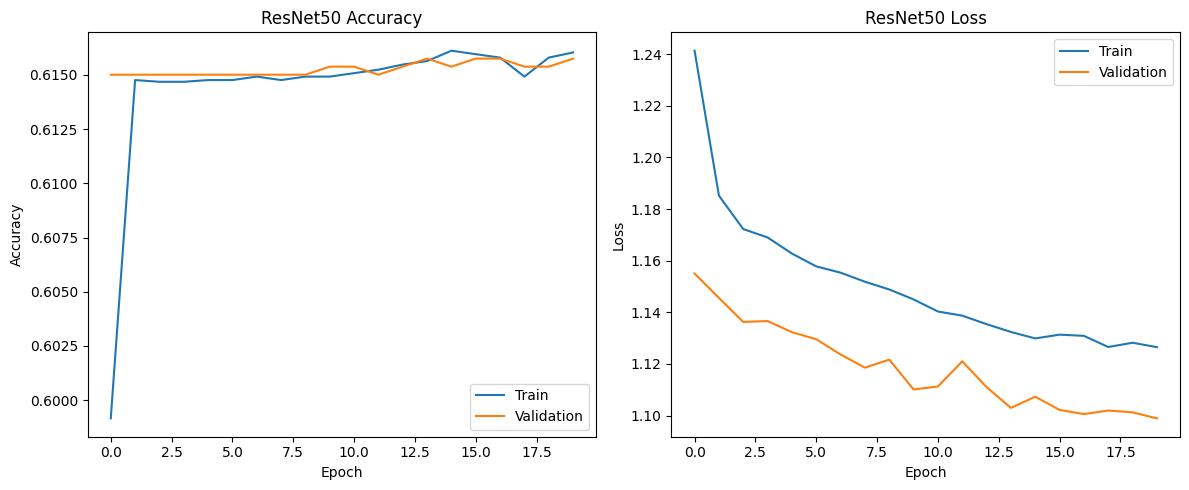

In [ ]:
# Plot accuracy/loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train')
plt.plot(history_resnet.history['val_accuracy'], label='Validation')
plt.title('ResNet50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train')
plt.plot(history_resnet.history['val_loss'], label='Validation')
plt.title('ResNet50 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step


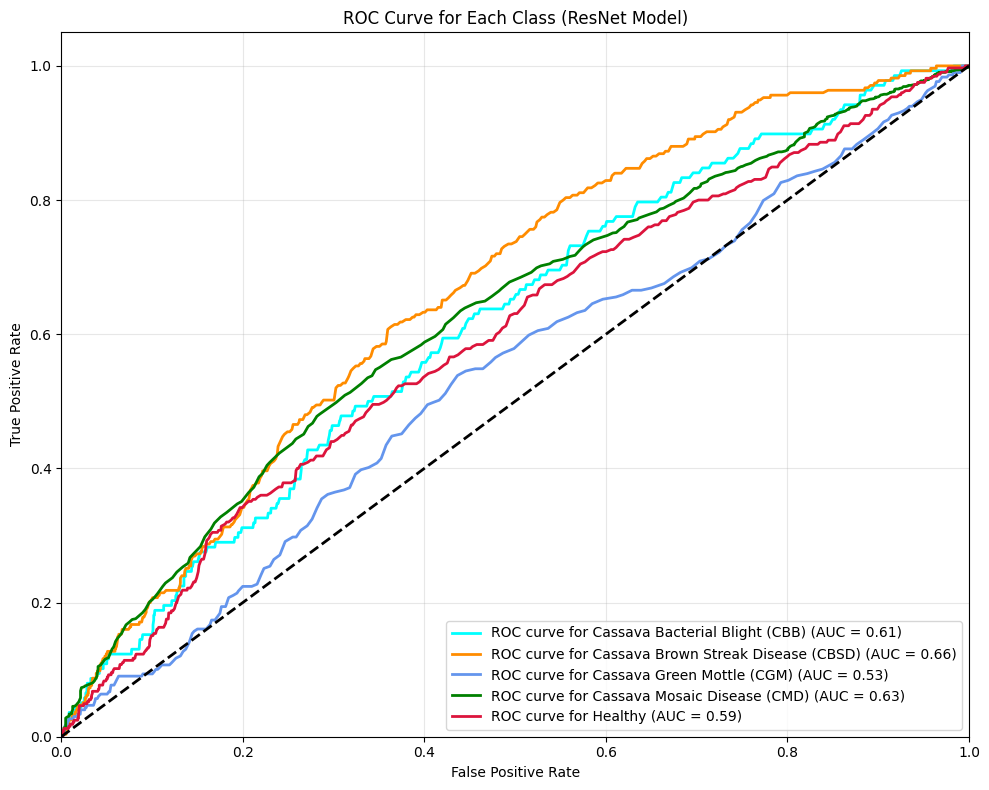

In [ ]:
# ResNet ROC Curve
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Class names in the same order as ResNet model's output
class_names = ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)',
               'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']

n_classes = len(class_names)

# True labels and predicted probabilities from ResNet
y_true = test_generator.classes
y_score = resnet_model.predict(test_generator)

# Binarize the true labels for ROC computation
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])

# Compute ROC curves and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'crimson'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (ResNet Model)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


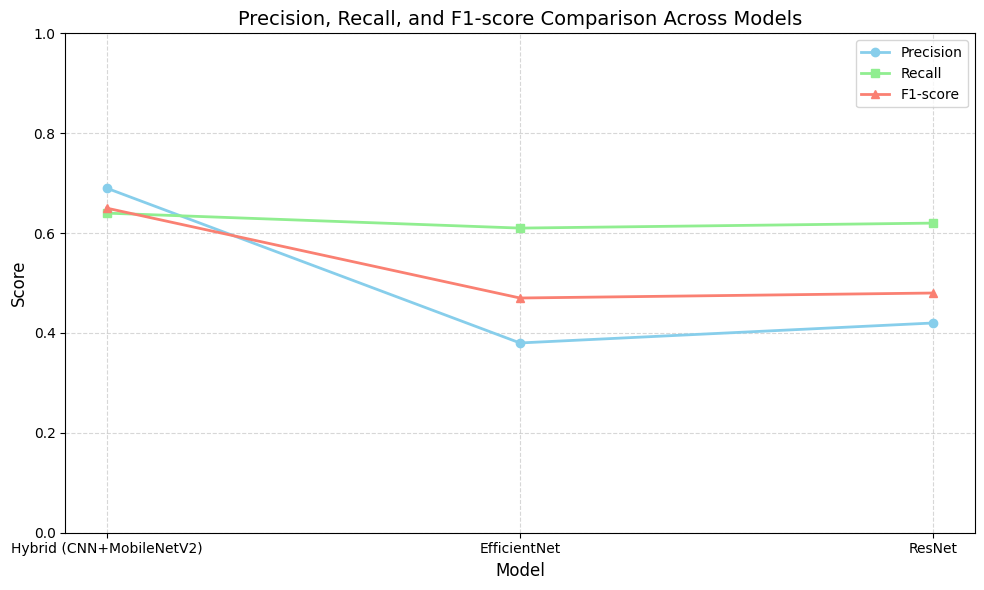

In [ ]:
import matplotlib.pyplot as plt

# Model names and metrics
model_names = ['Hybrid (CNN+MobileNetV2)', 'EfficientNet', 'ResNet']
precision_scores = [0.69, 0.38, 0.42]
recall_scores = [0.64, 0.61, 0.62]
f1_scores = [0.65, 0.47, 0.48]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(model_names, precision_scores, marker='o', label='Precision', color='skyblue', linewidth=2)
plt.plot(model_names, recall_scores, marker='s', label='Recall', color='lightgreen', linewidth=2)
plt.plot(model_names, f1_scores, marker='^', label='F1-score', color='salmon', linewidth=2)

# Title and labels
plt.title('Precision, Recall, and F1-score Comparison Across Models', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


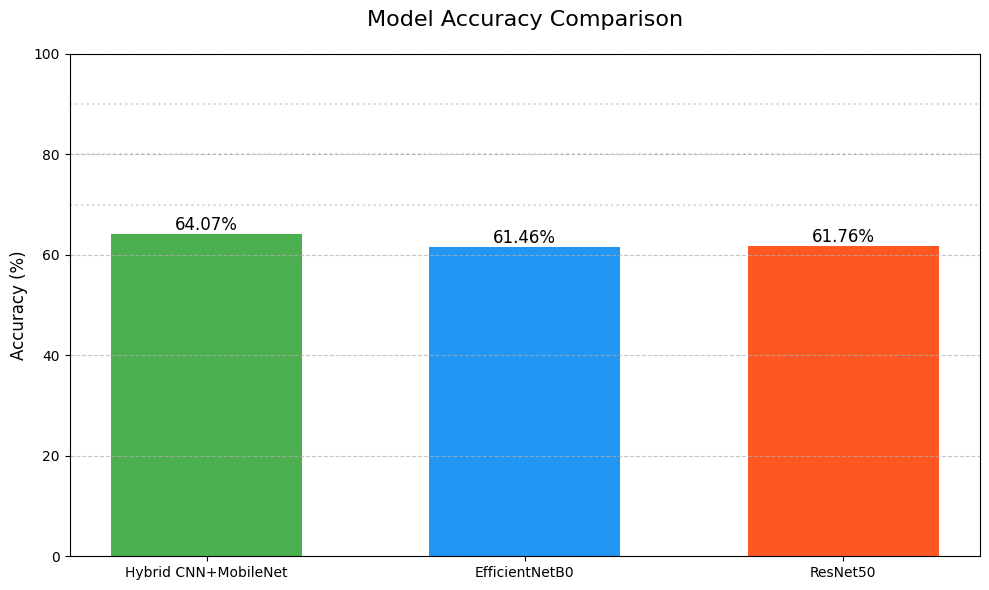

In [ ]:
#Model accuracy comparison
import matplotlib.pyplot as plt
import numpy as np

# Model names and their test accuracies
models = ['Hybrid CNN+MobileNet', 'EfficientNetB0', 'ResNet50']
accuracies = [test_acc, test_acc_efficientnet, test_acc_resnet]  # Use 'test_acc' instead of 'test_acc_hybrid'

# Create the comparison plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, [acc*100 for acc in accuracies],
               color=['#4CAF50', '#2196F3', '#FF5722'],  # Green, Blue, Orange
               width=0.6)

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom',
             fontsize=12)

# Customize the plot
plt.title('Model Accuracy Comparison', fontsize=16, pad=20)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 100)  # Set y-axis from 0-100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal line at important thresholds
for threshold in [70, 80, 90]:
    plt.axhline(y=threshold, color='gray', linestyle=':', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

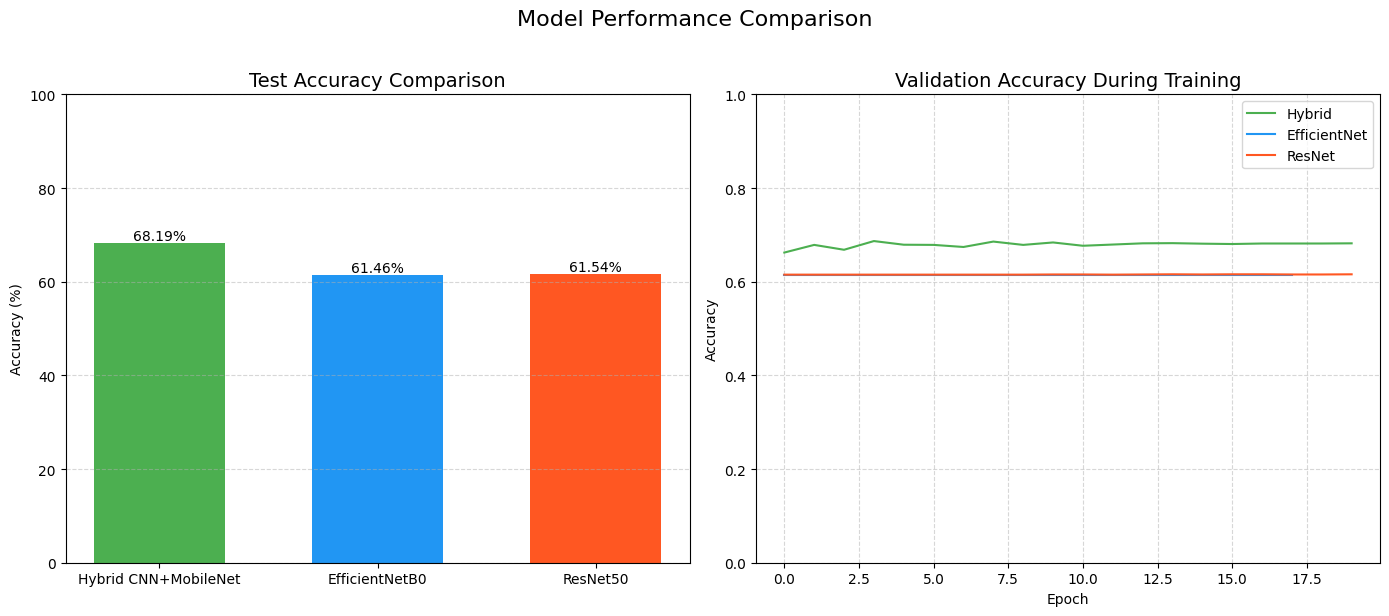

In [ ]:
plt.figure(figsize=(14, 6))

# 1. Accuracy Comparison Bars
plt.subplot(1, 2, 1)
bars = plt.bar(models, [acc*100 for acc in accuracies],
               color=['#4CAF50', '#2196F3', '#FF5722'],
               width=0.6)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%', ha='center', va='bottom')
plt.title('Test Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 2. Training Progress Comparison
plt.subplot(1, 2, 2)
# Assuming 'history' from a previous cell contains the Hybrid model's training history
plt.plot(history.history['val_accuracy'], label='Hybrid', color='#4CAF50')
plt.plot(history_efficientnet.history['val_accuracy'], label='EfficientNet', color='#2196F3')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet', color='#FF5722')
plt.title('Validation Accuracy During Training', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.ylim(0, 1)

plt.suptitle('Model Performance Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('full_comparison.png', dpi=300, bbox_inches='tight')
plt.show()